In [1]:
"""
Finding matching ICS records for NIFC perimeters.

Author: maxwell.cook@colorado.edu
"""

import os, sys
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.spatial import cKDTree
from shapely.geometry import Point

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
icsdir = os.path.join(maindir, 'ics209-plus-fired/data/')

print("Ready !")

Ready !


In [2]:
# Load some boundary data
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs(proj)
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [3]:
# Load the wildfire dataset
inci_path = os.path.join(icsdir, 'tabular/raw/wf-incidents/ics209-plus_v3.2/ics209-plus-wf_incidents_1999to2023.csv')
incidents = pd.read_csv(inci_path, low_memory=False)
incidents.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [4]:
# Tidy the columns
incidents.dropna(subset=['DISCOVERY_DATE'], inplace=True)
incidents['DISCOVERY_DATE'] = pd.to_datetime(incidents['DISCOVERY_DATE'])
incidents['START_YEAR'] = incidents['DISCOVERY_DATE'].dt.year
incidents['START_YEAR'] = incidents['START_YEAR'].astype(int)

# Filter to match NIFC fire years (2017 to 2023)
incidents = incidents[incidents['START_YEAR'] >= 2017]
print(f"There are [{len(incidents)}] ICS-209-PLUS incidents (2017-2023).")

There are [10646] ICS-209-PLUS incidents (2017-2023).


In [5]:
# Create a spatial points data from the ICS-209-PLUS records
geometry = [Point(xy) for xy in zip(incidents['POO_LONGITUDE'], incidents['POO_LATITUDE'])]

# Create a GeoDataFrame
ics = gpd.GeoDataFrame(incidents, geometry=geometry)
ics = ics.set_crs(epsg=4326, inplace=True) # set the crs
ics = ics.to_crs(proj) # reproject to EPSG:5070

print(f"There are [{len(ics)}] spatial points (2017-2023).")

# Intersect with state boundaries and match with POO_STATE
ics = gpd.sjoin(ics, states[['geometry', 'STUSPS']], how='inner', predicate='intersects')
ics = ics[ics['POO_STATE'] == ics['STUSPS']] # filter where states match
print(f"There are [{len(ics)}] spatial points matching state of origin (2017-2023).")

There are [10646] spatial points (2017-2023).
There are [10593] spatial points matching state of origin (2017-2023).


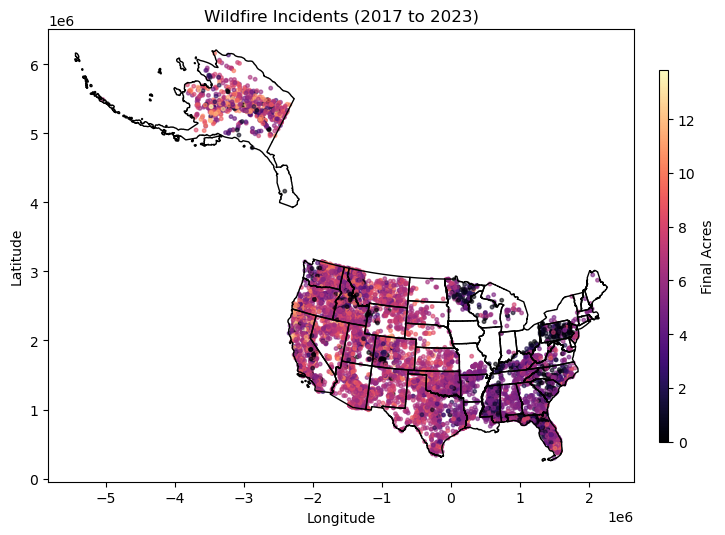

79

In [6]:
# Plot the incident reports.
# Filter the GeoDataFrame for points in Colorado
gdf = ics.copy()
gdf['log_FINAL_ACRS'] = np.log1p(gdf['FINAL_ACRES'])  # log1p to handle log(0) issues

# Plot the points on a map, with size based on FINAL_ACRES
fig, ax = plt.subplots(figsize=(8, 8))

# Normalize the FINAL_ACRES values for color mapping
norm = colors.Normalize(vmin=gdf['log_FINAL_ACRS'].min(), vmax=gdf['log_FINAL_ACRS'].max())

# Plot the points with size and color based on FINAL_ACRES
gdf.plot(ax=ax, marker='o',
         color=gdf['log_FINAL_ACRS'].apply(lambda x: cm.magma(norm(x))),
         alpha=0.6, markersize=6.5)

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Set title and labels
plt.title('Wildfire Incidents (2017 to 2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.015, pad=0.04, aspect=40)
cbar.set_label('Final Acres')

# Display the plot
plt.show()

del gdf
gc.collect()

In [7]:
# Subset to western U.S. ecoregions
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
print(ecol3.columns)

# Perform the overlay analysis
ics_west = gpd.overlay(ics, ecol3, how='intersection') # find overlaps
print(f"{len(ics_west)} ICS-209-PLUS incidents across western U.S. ecoregions in CONUS (2017-2023).")

Index(['na_l3name', 'geometry'], dtype='object')
4982 ICS-209-PLUS incidents across western U.S. ecoregions in CONUS (2017-2023).


In [8]:
# Save this file out.
out_fp = os.path.join(projdir, 'data/spatial/raw/ICS209PLUS/wf_incidents_spatial_west_2017to2023.gpkg')
ics_west.to_file(out_fp)
print(f"file exported to {out_fp}")

file exported to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/ICS209PLUS/wf_incidents_spatial_west_2017to2023.gpkg


In [9]:
# Load the fire census and find nearest neighbors.

In [10]:
fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023.gpkg')
fires = gpd.read_file(fp)
fires.columns

Index(['Fire_ID', 'Source', 'Fire_Name', 'Fire_Year', 'Start_Date',
       'Final_Acres', 'Fire_Type', 'na_l3name', 'pct_aspen', 'geometry'],
      dtype='object')

In [11]:
fires['Fire_Type'].unique()

array(['Wildfire Final Fire Perimeter', 'Wildfire',
       'Wildfire Daily Fire Perimeter', 'Prescribed Fire', 'Unknown'],
      dtype=object)

In [12]:
# filter out prescribed fires
fires = fires[fires['Fire_Type'] != 'Prescribed Fire']
print(f"{len(fires)} wildfires in the Southern Rockies (2017-2023).")

599 wildfires in the Southern Rockies (2017-2023).


In [13]:
print(ics_west.crs)
print(fires.crs)

EPSG:5070
EPSG:5070


In [14]:
# filter the ics to fires >= 100 acres (matching our fires)
ics_west = ics_west[ics_west['FINAL_ACRES'] >= 100]

# Identify matching fired perimiters and ics-209 incident reports
ics_nn, no_matches = find_nearest(
    fires, ics_west, 
    nn=10, max_dist=1e4, 
    max_size_diff=60 # allow for a pretty large size difference
)
print(f'Found {len(ics_nn)} matches;')

There were [427/599] fires with no matches.
Found 122 matches;


In [15]:
ics_nn.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [16]:
# Create a geodataframe and tidy the columns.
ics_nn_gdf = gpd.GeoDataFrame(ics_nn, geometry='geometry', crs=proj)
ics_nn_gdf = ics_nn_gdf[[
    'Fire_ID','Fire_Name','Final_Acres','Source', 'Start_Date', 'Aspen_Pct',
    'INCIDENT_ID','INCIDENT_NAME','START_YEAR','FINAL_ACRES','CAUSE',
    'DISCOVERY_DATE','DISCOVERY_DOY','WF_CESSATION_DATE','WF_CESSATION_DOY',
    'STR_DESTROYED_TOTAL','STR_DAMAGED_TOTAL','STR_THREATENED_MAX',
    'EVACUATION_REPORTED','PEAK_EVACUATIONS','WF_PEAK_AERIAL','WF_PEAK_PERSONNEL',
    'na_l3name', 'geometry'
]].rename(columns={'FINAL_ACRES': 'ICS_ACRES'})

# handle the date columns
date_cols = ['DISCOVERY_DATE','WF_CESSATION_DATE']
for col in date_cols:
    ics_nn_gdf[col] = pd.to_datetime(ics_nn_gdf[col], errors='coerce')

# Sort by fire size just for exploration
ics_nn_gdf.sort_values(by=['ICS_ACRES'], ascending=False, inplace=True)
ics_nn_gdf[['Fire_ID','Fire_Name','Final_Acres','INCIDENT_ID',
            'INCIDENT_NAME','START_YEAR','ICS_ACRES','na_l3name']].head(20) # the 10 largest fires

,Fire_ID,Fire_Name,Final_Acres,INCIDENT_ID,INCIDENT_NAME,START_YEAR,ICS_ACRES,na_l3name
121,16,CALF CANYON-HERMITS PEAK,346871.216392,2022_14425222_HERMITS PEAK,Hermits Peak,2022,341735.0,Southern Rockies
43,48,CAMERON PEAK,208760.3,2020_11856938_CAMERON PEAK,Cameron Peak,2020,208913.0,Southern Rockies
83,89,EAST TROUBLESOME,193693.9,2020_11966782_EAST TROUBLESOME,EAST TROUBLESOME,2020,193812.0,Southern Rockies
84,90,MULLEN,176787.2,2020_11917747_MULLEN,MULLEN,2020,176878.0,Southern Rockies
101,110,SPRING CREEK,108131.3,2018_9201669_SPRING CREEK,Spring Creek,2018,108045.0,Southern Rockies
108,119,COOKS PEAK,61195.0,2022_14445094_COOKS PEAK,Cooks Peak,2022,59359.0,Southern Rockies
0,0,416,54130.98,2018_9091030_416,416,2018,54129.0,Southern Rockies
36,41,CERRO PELADO,45604.81,2022_14454770_CERRO PELADO,Cerro Pelado,2022,45605.0,Southern Rockies
109,131,UTE PARK,30177.0,2018_9183839_UTE PARK,Ute Park,2018,36740.0,Southern Rockies
50,55,BULL DRAW,36549.14,2018_9093430_BULL DRAW,Bull Draw,2018,36520.0,Colorado Plateaus


In [17]:
ics_nn_gdf.columns

Index(['Fire_ID', 'Fire_Name', 'Final_Acres', 'Source', 'Start_Date',
       'Aspen_Pct', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES',
       'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')

In [18]:
# check for duplicates
duplicates = ics_nn_gdf[ics_nn_gdf['INCIDENT_ID'].duplicated(keep=False)]
duplicates.sort_values(by=['INCIDENT_NAME'], ascending=False, inplace=True)
# ensure date format
duplicates['Start_Date'] = pd.to_datetime(duplicates['Start_Date'], errors='coerce')
duplicates['DISCOVERY_DATE'] = pd.to_datetime(duplicates['DISCOVERY_DATE'], errors='coerce')
duplicates['Final_Acres'] = pd.to_numeric(duplicates['Final_Acres'], errors='coerce')
duplicates['ICS_ACRES'] = pd.to_numeric(duplicates['ICS_ACRES'], errors='coerce')
duplicates[['Fire_ID','Fire_Name','Final_Acres','Start_Date','Source','INCIDENT_NAME','DISCOVERY_DATE','ICS_ACRES']].head(len(duplicates))

,Fire_ID,Fire_Name,Final_Acres,Start_Date,Source,INCIDENT_NAME,DISCOVERY_DATE,ICS_ACRES
114,427,NaN,371.303193,2018-10-21,FIRED,Turner,2018-08-07 15:17:00,150.0
116,432,NaN,106.086626,2018-10-20,FIRED,Turner,2018-08-07 15:17:00,150.0
115,431,NaN,159.129940,2018-10-22,FIRED,Turner,2018-08-07 15:17:00,150.0
113,426,NaN,265.216566,2018-10-21,FIRED,Turner,2018-08-07 15:17:00,150.0
102,111,RYAN,28243.650000,NaT,NIFC,RYAN,2018-09-15 20:36:00,28585.0
91,97,RYAN,28585.430000,NaT,NIFC,RYAN,2018-09-15 20:36:00,28585.0
10,10,MILL CREEK 2,159.810000,NaT,NIFC,Mill Creek 2,2023-10-19 11:55:00,150.0
117,511,NaN,371.303193,2023-10-18,FIRED,Mill Creek 2,2023-10-19 11:55:00,150.0
118,599,NaN,159.129940,2021-11-11,FIRED,Kruger Mountain,2021-11-16 08:08:00,147.0
69,74,KRUGER MOUNTAIN,146.620000,NaT,NIFC,Kruger Mountain,2021-11-16 08:08:00,147.0


In [19]:
# handle duplicates
def resolve_duplicates(group):
    # If there's an NIFC record, keep it
    if 'NIFC' in group['Source'].values:
        return group[group['Source'] == 'NIFC']
    
    # Otherwise, calculate size and date differences for FIRED and MTBS
    group['size_diff'] = (group['Final_Acres'] - group['ICS_ACRES']).abs()
    group['date_diff'] = (group['Start_Date'] - group['DISCOVERY_DATE']).abs()
    
    # Keep the record with the smallest size difference, then date difference within 7 days
    filtered = group.sort_values(by=['size_diff', 'date_diff'])
    filtered = filtered[filtered['date_diff'] <= pd.Timedelta(days=7)]
    
    # If no records remain, return the smallest size difference
    if filtered.empty:
        return group.nsmallest(1, 'size_diff')
    return filtered.head(1)

# Apply resolution logic
resolved = duplicates.groupby('INCIDENT_NAME').apply(resolve_duplicates).reset_index(drop=True)

# Step 3: Combine resolved duplicates with non-duplicates
non_duplicates = ics_nn_gdf[~ics_nn_gdf['INCIDENT_NAME'].duplicated(keep=False)]
ics_perims = pd.concat([non_duplicates, resolved], ignore_index=True)
ics_perims.drop(columns=['size_diff','date_diff'], inplace=True)
ics_perims = gpd.GeoDataFrame(ics_perims)
print(f"[{len(ics_perims)}] fires remaining, joined with ICS.")
print(ics_perims.columns)

# handle the date columns
ics_perims.drop(columns=['Start_Date'], inplace=True)
ics_perims['DISCOVERY_DATE']= ics_perims['DISCOVERY_DATE'].dt.strftime('%Y-%m-%d')
ics_perims['WF_CESSATION_DATE'] = ics_perims['WF_CESSATION_DATE'].dt.strftime('%Y-%m-%d')
ics_perims[['Fire_ID','Fire_Name','DISCOVERY_DATE','WF_CESSATION_DATE']].head()

[115] fires remaining, joined with ICS.
Index(['Fire_ID', 'Fire_Name', 'Final_Acres', 'Source', 'Start_Date',
       'Aspen_Pct', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES',
       'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')


,Fire_ID,Fire_Name,DISCOVERY_DATE,WF_CESSATION_DATE
0,16,CALF CANYON-HERMITS PEAK,2022-04-06,2022-06-14
1,48,CAMERON PEAK,2020-08-13,2020-10-17
2,89,EAST TROUBLESOME,2020-10-14,2020-10-23
3,90,MULLEN,2020-09-17,2020-10-08
4,110,SPRING CREEK,2018-06-27,2018-07-05


In [20]:
print(ics_perims.dtypes)

Fire_ID                  object
Fire_Name                object
Final_Acres              object
Source                   object
Aspen_Pct                object
INCIDENT_ID              object
INCIDENT_NAME            object
START_YEAR               object
ICS_ACRES                object
CAUSE                    object
DISCOVERY_DATE           object
DISCOVERY_DOY            object
WF_CESSATION_DATE        object
WF_CESSATION_DOY         object
STR_DESTROYED_TOTAL      object
STR_DAMAGED_TOTAL        object
STR_THREATENED_MAX       object
EVACUATION_REPORTED      object
PEAK_EVACUATIONS         object
WF_PEAK_AERIAL           object
WF_PEAK_PERSONNEL        object
na_l3name                object
geometry               geometry
dtype: object


In [21]:
print(f"Geometry set to fire perimeters: {ics_perims.geom_type.unique()}")

Geometry set to fire perimeters: ['Point']


In [22]:
# Save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/ICS209PLUS/srm_fire_census_2017_to_2023_ics_points.gpkg')
ics_perims.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/ICS209PLUS/srm_fire_census_2017_to_2023_ics_points.gpkg


In [23]:
# Join perimeter data to ICS-209-PLUS
ics_perims.drop(columns=['geometry'], inplace=True)
fires_ics = pd.merge(fires[['Fire_ID','geometry']], ics_perims, on='Fire_ID', how='right')
fires_ics = gpd.GeoDataFrame(fires_ics)
fires_ics.columns

Index(['Fire_ID', 'geometry', 'Fire_Name', 'Final_Acres', 'Source',
       'Aspen_Pct', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES',
       'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name'],
      dtype='object')

In [24]:
# Check geometry type.
print(f"Geometry set to: {fires_ics.geom_type.unique()}")

Geometry set to: ['MultiPolygon' 'Polygon']


In [25]:
out_fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023_ics_perims.gpkg')
fires_ics.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/srm_fire_census_2017_to_2023_ics_perims.gpkg


In [26]:
# save a fire perimeter dataset for GEE CBI calculation

In [27]:
fires_ics.columns

Index(['Fire_ID', 'geometry', 'Fire_Name', 'Final_Acres', 'Source',
       'Aspen_Pct', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES',
       'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name'],
      dtype='object')

In [28]:
buffer = 10000 # meters
# Group by fire ID
grouped = fires_ics.groupby('Fire_ID')
bounds_gdf = gpd.GeoDataFrame(columns=['Fire_ID', 'geometry'], crs=fires_ics.crs)

# Iterate over each fire group
for fire_id, group in grouped:
    # Get all geometries in the group
    geoms = group.geometry.unary_union  # Combine all geometries into one MultiPolygon/Polygon
    bounds = geoms.convex_hull.buffer(buffer)

    # Create a GeoDataFrame for this fire with the buffered convex hull
    fire_bounds = gpd.GeoDataFrame({'Fire_ID': [fire_id], 'geometry': [bounds]}, crs=fires_ics.crs)

    # Append the result to the GeoDataFrame
    bounds_gdf = pd.concat([bounds_gdf, fire_bounds], ignore_index=True)

# Dissolve by NIFC_ID
afd_fire_bounds = bounds_gdf.dissolve(by='Fire_ID')
afd_fire_bounds = pd.merge(afd_fire_bounds, fires_ics.drop(columns=['geometry']), on='Fire_ID', how='left')
print(len(afd_fire_bounds['Fire_ID'].unique()))
print(afd_fire_bounds.columns)

115
Index(['Fire_ID', 'geometry', 'Fire_Name', 'Final_Acres', 'Source',
       'Aspen_Pct', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES',
       'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name'],
      dtype='object')


In [29]:
out_fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023_ics_bounds.gpkg')
afd_fire_bounds.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/srm_fire_census_2017_to_2023_ics_bounds.gpkg


In [33]:
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs(proj)
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [34]:
centroid = afd_fire_bounds.copy()
centroid['geometry'] = centroid.geometry.centroid
fire_state = gpd.overlay(centroid[['Fire_ID','geometry']], states[['STUSPS','geometry']], how='intersection')
fire_state = fire_state[['Fire_ID','STUSPS']]
afd_fire_bounds_ = pd.merge(afd_fire_bounds, fire_state, on='Fire_ID', how='left')
afd_fire_bounds_.columns

Index(['Fire_ID', 'geometry', 'Fire_Name', 'Final_Acres', 'Source',
       'Aspen_Pct', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'ICS_ACRES',
       'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name', 'STUSPS'],
      dtype='object')

In [35]:
# Assign the Parks et al. (2019) start and end days
special_case = ['Arizona', 'New Mexico']
afd_fire_bounds_['Start_Day'] = None
afd_fire_bounds_['End_Day'] = None    

afd_fire_bounds_.loc[afd_fire_bounds_['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (91, 181)
afd_fire_bounds_.loc[~afd_fire_bounds_['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (152, 258)

afd_fire_bounds_ = afd_fire_bounds_[['Fire_ID','Fire_Name','DISCOVERY_DOY','WF_CESSATION_DOY','START_YEAR','Start_Day','End_Day','na_l3name','geometry']]
afd_fire_bounds_ = afd_fire_bounds_.rename(columns={
    'START_YEAR': 'Fire_Year',
    'DISCOVERY_DOY': 'ICS_Ig_DOY',
    'WF_CESSATION_DOY': 'ICS_Cs_DOY'
})
afd_fire_bounds_['ICS_Ig_DOY'] = afd_fire_bounds_['ICS_Ig_DOY'].astype(int)
afd_fire_bounds_['ICS_Cs_DOY'] = afd_fire_bounds_['ICS_Cs_DOY'].astype(int)
afd_fire_bounds_.head()

,Fire_ID,Fire_Name,ICS_Ig_DOY,ICS_Cs_DOY,Fire_Year,Start_Day,End_Day,na_l3name,geometry
0,0,416,152,184,2018,152,258,Southern Rockies,"POLYGON ((-1038322.649 1649067.456, -1039312.5..."
1,1,PLATEAU,203,229,2018,152,258,Southern Rockies,"POLYGON ((-1092629.379 1673572.586, -1093110.3..."
2,2,PLUMTAW,137,138,2022,152,258,Southern Rockies,"POLYGON ((-968210.695 1637938.791, -968814.902..."
3,4,CHRIS MOUNTAIN,179,185,2023,152,258,Southern Rockies,"POLYGON ((-982809.971 1629990.703, -983805.271..."
4,5,DRY LAKE,213,217,2023,152,258,Southern Rockies,"POLYGON ((-995996.831 1628863.908, -996313.398..."


In [36]:
# save this file out for GEE.
out_fp = os.path.join(projdir, f'data/earth-engine/imports/srm_fire_census_2017_to_2023_bounds.shp')
afd_fire_bounds_.to_file(out_fp)
print(f"Saved to {out_fp}\n")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/srm_fire_census_2017_to_2023_bounds.shp

